In [48]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import random
import json
from networkx.readwrite import json_graph

# Função auxiliar para converter tipos do NumPy para tipos nativos do Python
def convert_to_native(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, (list, tuple)):
        return [convert_to_native(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: convert_to_native(value) for key, value in obj.items()}
    else:
        return obj

# Função para criar o grafo de grid
def create_city_grid(rows, cols):
    grid = nx.grid_2d_graph(rows, cols)
    mapping = {(x, y): f"{x},{y}" for x, y in grid.nodes()}
    return nx.relabel_nodes(grid, mapping)

# Função para calcular posições
def calculate_positions(grid):
    return {node: (int(node.split(",")[1]), -int(node.split(",")[0])) for node in grid.nodes()}

# Função para clusterizar os nós
def cluster_nodes(grid, regions, positions):
    node_positions = np.array([positions[node] for node in grid.nodes()])
    kmeans = KMeans(n_clusters=regions, random_state=42).fit(node_positions)
    labels = kmeans.labels_
    return labels

# Função para criar ruas
def create_streets(grid, regions, edge_regions, min_street, max_street):
    streets = {}
    edge_street_map = {}
    street_id = 1

    def create_street(edges, direction):
        nonlocal street_id
        street_edges = []
        current_length = 0
        edges = sorted(edges, key=lambda edge: (
            int(edge[0].split(",")[0]), int(edge[0].split(",")[1])) if direction == "horizontal" else (
            int(edge[0].split(",")[1]), int(edge[0].split(",")[0]))
        )
        last_line = None
        for edge in edges:
            current_line = int(edge[0].split(",")[0]) if direction == "horizontal" else int(edge[0].split(",")[1])
            if current_line != last_line or current_length >= max_street or (current_length >= min_street and random.random() > 0.5):
                if street_edges:
                    for e in street_edges:
                        edge_street_map[e] = street_id
                    streets[street_id] = street_edges
                    street_id += 1
                street_edges = []
                current_length = 0
            street_edges.append(edge)
            current_length += 1
            last_line = current_line
        if street_edges:
            for e in street_edges:
                edge_street_map[e] = street_id
            streets[street_id] = street_edges
            street_id += 1

    for region in range(regions):
        region_edges = [edge for edge in grid.edges() if edge_regions[edge] == region]
        horizontal_edges = [edge for edge in region_edges if edge[0].split(",")[0] == edge[1].split(",")[0]]
        vertical_edges = [edge for edge in region_edges if edge[0].split(",")[1] == edge[1].split(",")[1]]
        create_street(horizontal_edges, "horizontal")
        create_street(vertical_edges, "vertical")

    return streets, edge_street_map

# Função para atribuir atributos aos nós
def assign_node_attributes(grid):
    node_ids = {node_label: idx for idx, node_label in enumerate(grid.nodes())}
    for node_label in grid.nodes():
        grid.nodes[node_label]['id_vertex'] = node_ids[node_label]
        grid.nodes[node_label]['isMetroStation'] = False
    return node_ids

# Função para atribuir atributos às arestas
def assign_edge_attributes(grid, edge_street_map, edge_regions, min_street, max_street, trafic_rate_random=True):
    street_numbers = {sid: random.randint(1000, 9999) for sid in edge_street_map.values()}
    region_ceps = {region: random.randint(100000, 999999) for region in set(edge_regions.values())}
    for idx, edge in enumerate(grid.edges()):
        street_id = edge_street_map.get(edge, None)
        region = edge_regions.get(edge, None)
        if street_id is not None and region is not None:
            traficRate = random.uniform(0, 1) if trafic_rate_random else 1
            distance = random.uniform(min_street, max_street)  # Distância aleatória entre min_street e max_street
            grid.edges[edge]['id_edge'] = idx
            grid.edges[edge]['street_number'] = int(street_numbers[street_id])
            grid.edges[edge]['cep'] = int(region_ceps[region])
            grid.edges[edge]['traficRate'] = float(traficRate)
            grid.edges[edge]['distance'] = int(distance)  # Garantir tipo float para compatibilidade

# Função para exportar o grafo para JSON
def export_to_json(grid, node_ids, filepath):
    data = json_graph.node_link_data(grid)
    data = convert_to_native(data)
    data['vertex'] = data.pop('nodes')
    data['edges'] = data.pop('links')
    for node in data['vertex']:
        node['id_vertex'] = node.pop('id_vertex')
        node['isMetroStation'] = node.pop('isMetroStation')
        node.pop('id', None)
        node.pop('pos', None)
    for edge in data['edges']:
        edge['id_edge'] = edge.pop('id_edge')
        edge['v1'] = node_ids[edge.pop('source')]
        edge['v2'] = node_ids[edge.pop('target')]
        edge.pop('key', None)
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)


# Função principal para criar e configurar o grafo da cidade
def city(rows, cols,  min_street, max_street, regions, trafic_rate_random, filepath="city_graph_novo.json"):
    city_grid = create_city_grid(rows, cols)
    pos = calculate_positions(city_grid)
    labels = cluster_nodes(city_grid, regions, pos)
    region_colors = {i: plt.cm.tab10(i / regions) for i in range(regions)}
    edge_regions = {edge: labels[list(city_grid.nodes()).index(edge[0])] for edge in city_grid.edges()}
    streets, edge_street_map = create_streets(city_grid, regions, edge_regions, min_street, max_street)
    node_ids = assign_node_attributes(city_grid)  # Atribuir atributos aos nós
    assign_edge_attributes(city_grid, edge_street_map, edge_regions, min_street, max_street, trafic_rate_random)
    export_to_json(city_grid, node_ids, filepath)

    return city_grid, pos, edge_regions, region_colors, edge_street_map

In [46]:
# Executar
city_grid, pos, edge_regions, region_colors, edge_street_map = city(15, 15, 80, 100, 12, trafic_rate_random=True, filepath="city_graph.json")


# Criando lista de cores para as arestas com base na região
edge_colors = [region_colors[edge_regions[edge]] for edge in city_grid.edges()]

c:\Users\Paula Eduarda\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


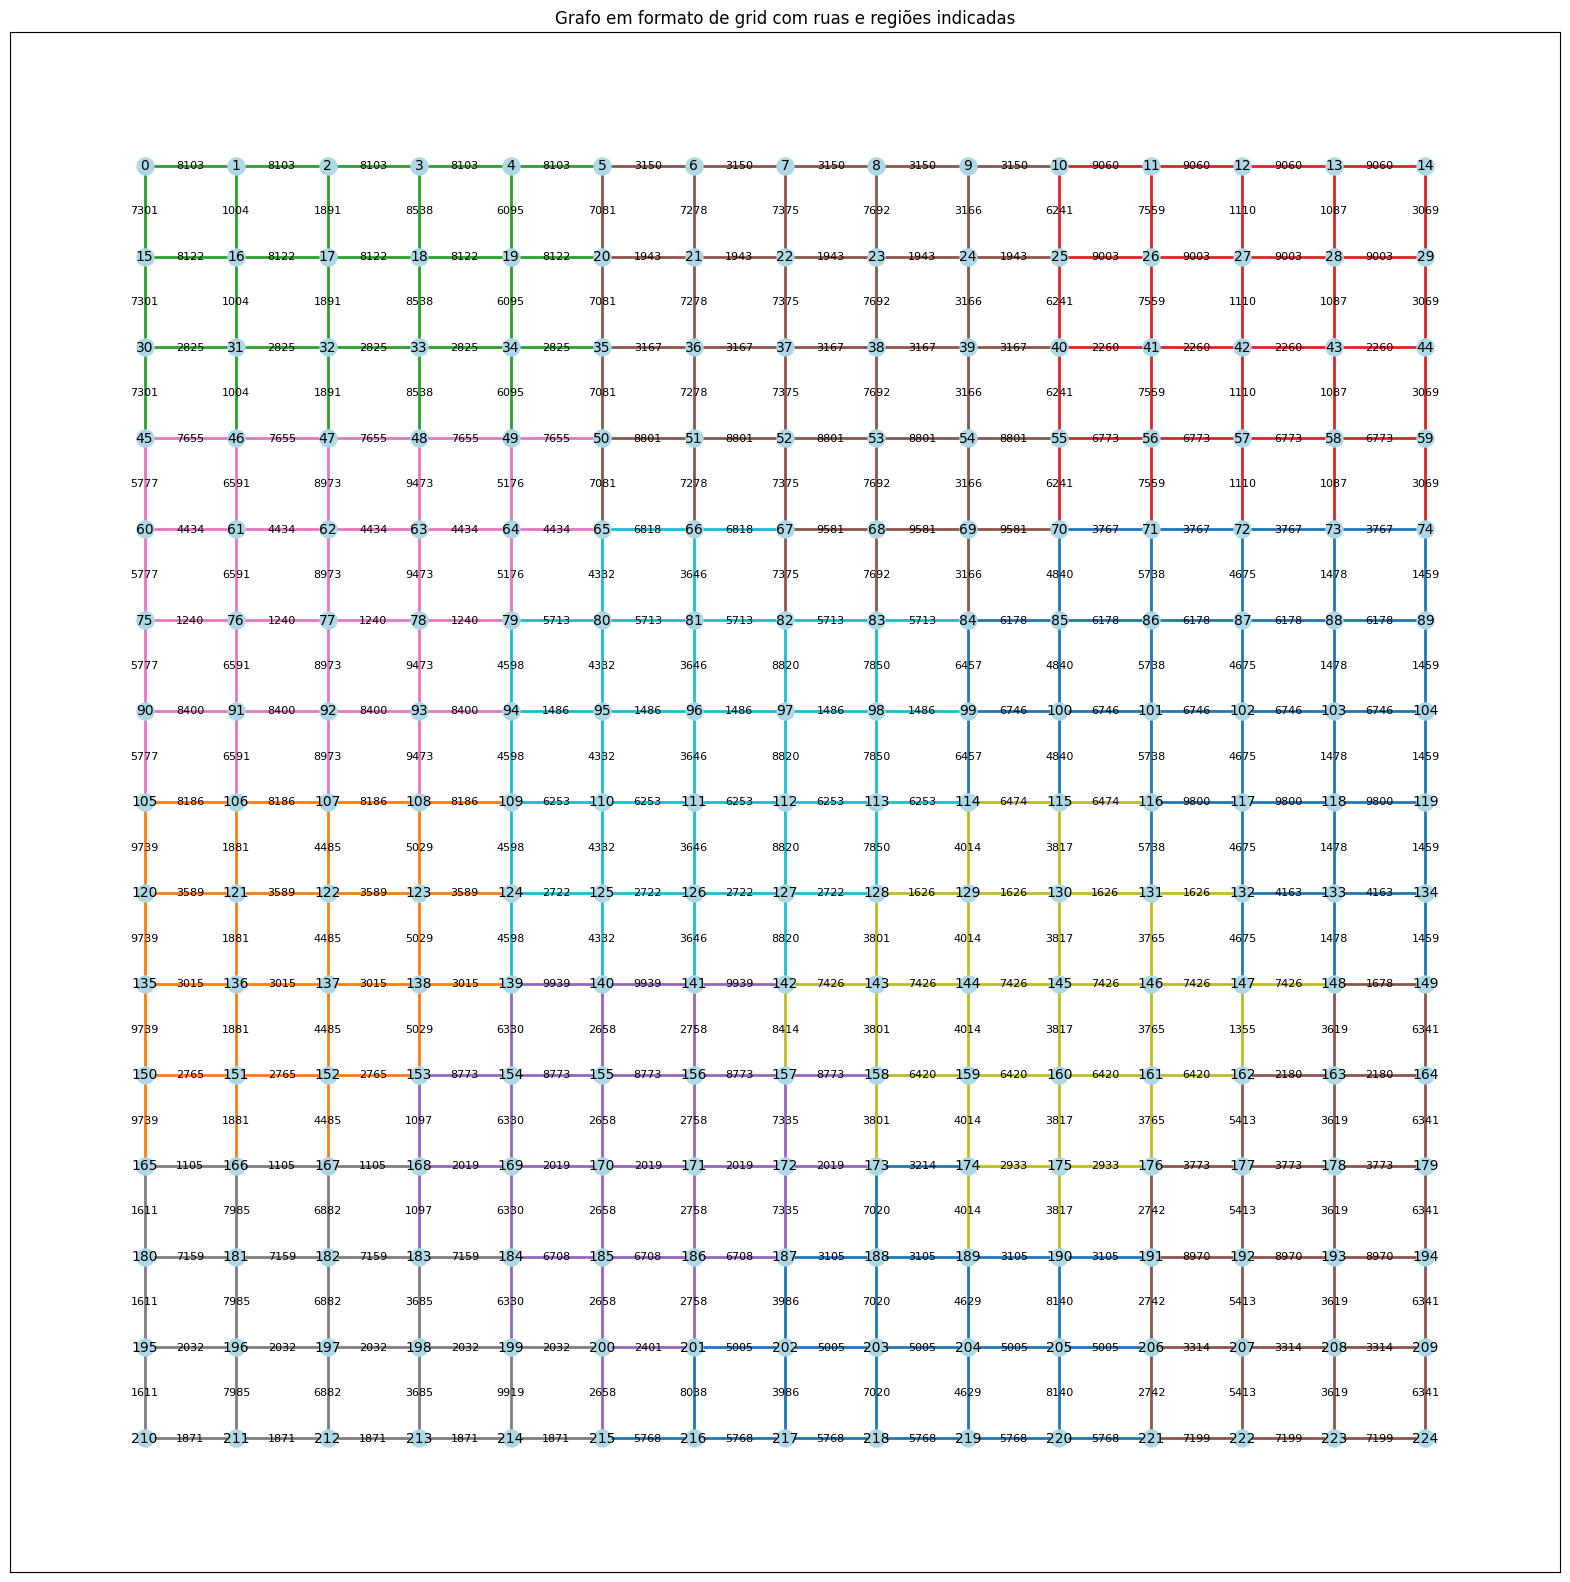

In [47]:
import networkx as nx
import matplotlib.pyplot as plt

# Plotando o grafo com ruas
plt.figure(figsize=(20, 20))

# Desenhando as arestas do grafo
nx.draw_networkx_edges(
    city_grid,
    pos,
    edge_color=edge_colors,
    width=2,
)

# Alterar os rótulos para mostrar o ID do vértice
labels = {node: city_grid.nodes[node]['id_vertex'] for node in city_grid.nodes()}
nx.draw_networkx_nodes(city_grid, pos, node_color='lightblue', node_size=150)
nx.draw_networkx_labels(city_grid, pos, labels=labels, font_size=10, font_color='black')

# Adicionando etiquetas para identificar as ruas
for edge in city_grid.edges():
    if edge in edge_street_map:
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2
        plt.text(mid_x, mid_y, str(city_grid.edges[edge]['street_number']), fontsize=8, color="black", ha="center", va="center")

plt.title("Grafo em formato de grid com ruas e regiões indicadas")
plt.show()


In [ ]:
# Cria grafos de diferentes tamanhos para testes de complexidades
import os

# Criar diretório para salvar os arquivos de teste
output_dir = "./graph_tests"  # Caminho relativo
os.makedirs(output_dir, exist_ok=True)

# Lista de tamanhos para os grafos
sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Função para salvar os grafos de teste
def generate_test_graphs(sizes, output_dir):
    results = []
    for size in sizes:
        filename = f"city_graph_{size}x{size}.json"
        filepath = os.path.join(output_dir, filename)
        
        # Criar o grafo e salvar o JSON
        grid, pos, edge_regions, region_colors, edge_street_map = city(
            size, size, min_street=80, max_street=100, regions= int(size/2), trafic_rate_random=False, filepath=filepath
        )
        
    return results

test_results = generate_test_graphs(sizes, output_dir)


c:\Users\Paula Eduarda\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(
c:\Users\Paula Eduarda\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(
c:\Users\Paula Eduarda\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The